## Brief description of the problem and data (5 pts)


**Goal:** In this mini-project, I aim to build a machine learning model that can accurately classify tweets as either describing real disasters or not. The goal is to build a model that predicts whether a given tweet is describing a real disaster (label = 1) or not (label = 0). This project covers:
 (target = 0).  

#### Data Description

* Training Data Size: 7,613 tweets
* Test Data Size: 3,263 tweets
* Dimensions: 5 columns in training data (id, keyword, location, text, target)
* Structure: Each row represents a single tweet with metadata

##### Data Features

* id: Unique identifier for each tweet
* text: The actual tweet content (main feature for classification)
* keyword: Optional keyword extracted from the tweet (may be blank)
* location:  the location the tweet was sent from (may be blank)
* target: in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

### Importing Libraries and Loading the Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from wordcloud import WordCloud, STOPWORDS
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2025-06-04 12:41:07.463518: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749040867.770376      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749040867.856405      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Exploratory Data Analysis (EDA)

In [3]:
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_df  = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

print(f"train shape : {train_df.shape}")
print(f"test  shape : {test_df.shape}")

train_df.head()

train shape : (7613, 5)
test  shape : (3263, 4)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


#### Checking for missing values

In [4]:
print("train missing values:")
print(train_df.isnull().sum())
print("\ntest missing values:")
print(test_df.isnull().sum())

train missing values:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

test missing values:
id             0
keyword       26
location    1105
text           0
dtype: int64


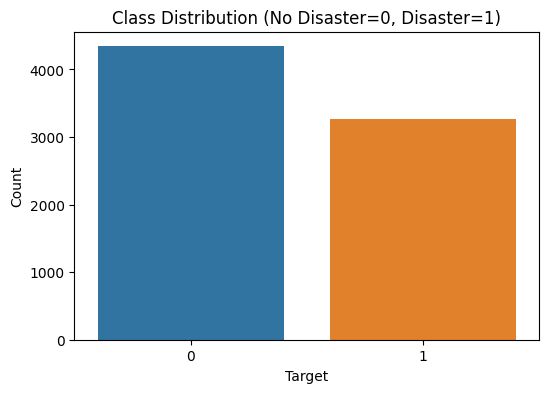

In [5]:
plt.figure(figsize=(6,4))
sns.countplot(x="target", data=train_df)
plt.title("Class Distribution (No Disaster=0, Disaster=1)")
plt.ylabel("Count")
plt.xlabel("Target")
plt.show()

* We can observe almost 60% percent of our data is No Disaster, and 40% of them are Disaster. Data slightly imbalanced.

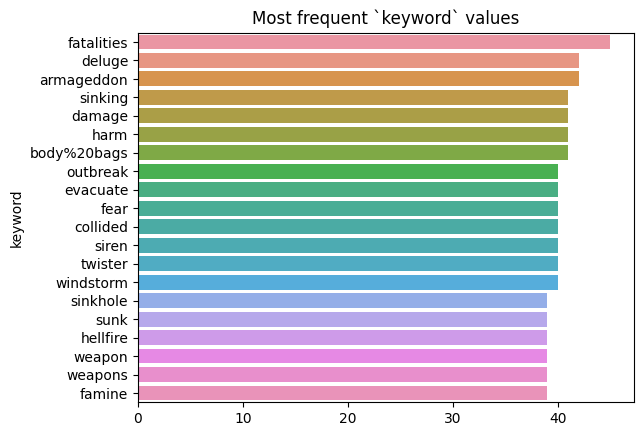

In [7]:
top_kw = train_df['keyword'].dropna().value_counts().head(20)
sns.barplot(y=top_kw.index, x=top_kw.values)
plt.title("Most frequent `keyword` values");

 * My observation about top 10 keywords are; they are usually seems related disaster, for that purpose I am going to compare them with Target variable to see whether my assumption correct or not. 

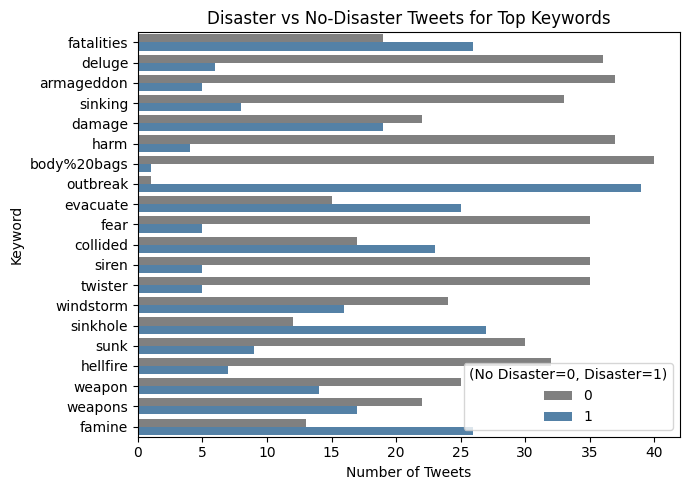

In [9]:
top_kw = train_df['keyword'].dropna().value_counts().head(20)
kw_list = top_kw.index.tolist()

#get top 10
subset = train_df[train_df['keyword'].isin(kw_list)]


plt.figure(figsize=(7, 5))
sns.countplot(
    data=subset,
    y='keyword',
    hue='target',        
    order=kw_list,
    palette={0: "gray", 1: "steelblue"}
)
plt.title("Disaster vs No‐Disaster Tweets for Top Keywords")
plt.xlabel("Number of Tweets")
plt.ylabel("Keyword")
plt.legend(title="(No Disaster=0, Disaster=1)")
plt.tight_layout()
plt.show()

* My assumption wasn't correct, even if those words seems related with a disasterm they seems not related like I thougt. 

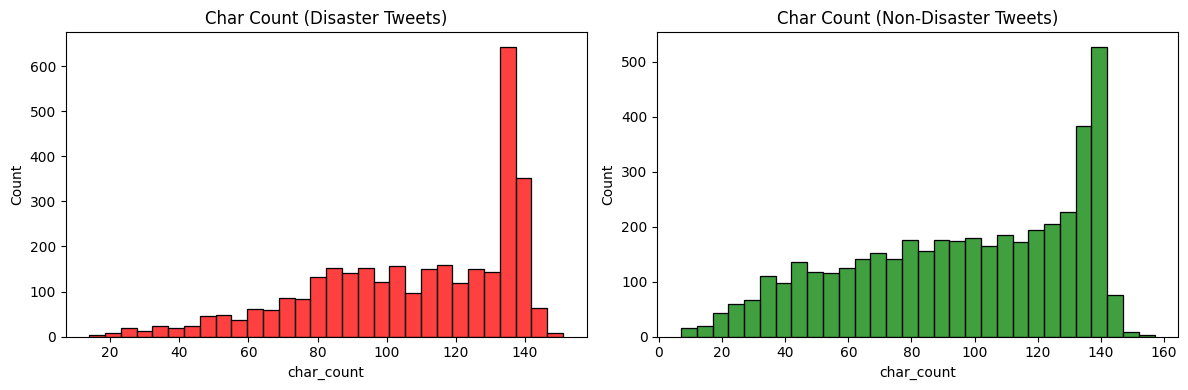

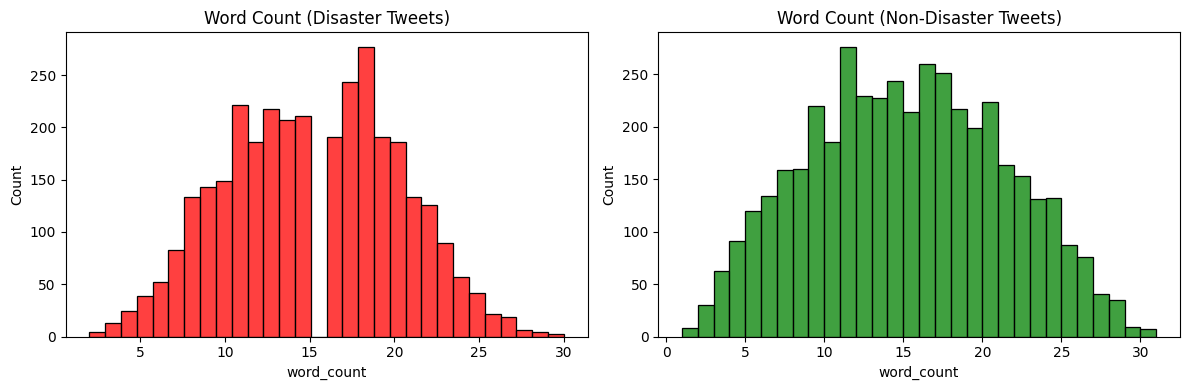

In [10]:
#tweet length and word count
train_df["char_count"] = train_df["text"].apply(len)
train_df["word_count"] = train_df["text"].str.split().map(len)

fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(train_df[train_df["target"]==1]["char_count"], bins=30, ax=axes[0], color="red")
axes[0].set_title("Char Count (Disaster Tweets)")
sns.histplot(train_df[train_df["target"]==0]["char_count"], bins=30, ax=axes[1], color="green")
axes[1].set_title("Char Count (Non-Disaster Tweets)")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(train_df[train_df["target"]==1]["word_count"], bins=30, ax=axes[0], color="red")
axes[0].set_title("Word Count (Disaster Tweets)")
sns.histplot(train_df[train_df["target"]==0]["word_count"], bins=30, ax=axes[1], color="green")
axes[1].set_title("Word Count (Non-Disaster Tweets)")
plt.tight_layout()
plt.show()


* Charter count seems left skewed in both disaster and non disaster tweets and they also show similar characteristic.
* Word count seems to have bea ll shape more like a normal distribution, with similar characteristic.
* Good thing about these visual we can say that our training data represents the test data characteristics according these statistics. 

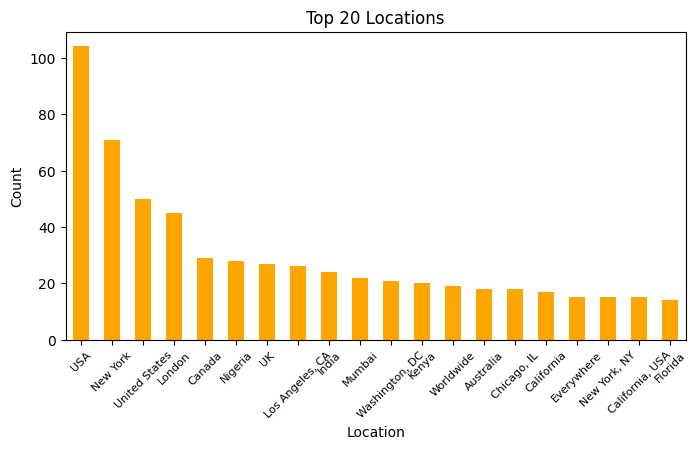

In [11]:

# top 20 locations
plt.figure(figsize=(8,4))
train_df["location"].value_counts().dropna().head(20).plot(kind="bar", color="orange")
plt.title("Top 20 Locations")
plt.xlabel("Location")
plt.ylabel("Count")
plt.xticks(rotation=45, fontsize=8)
plt.show()

* Location are mostly USA and US states. There are some from UK and Nigeria and India.
* I am going to compare top 10 location and target value to see the is there any relation.

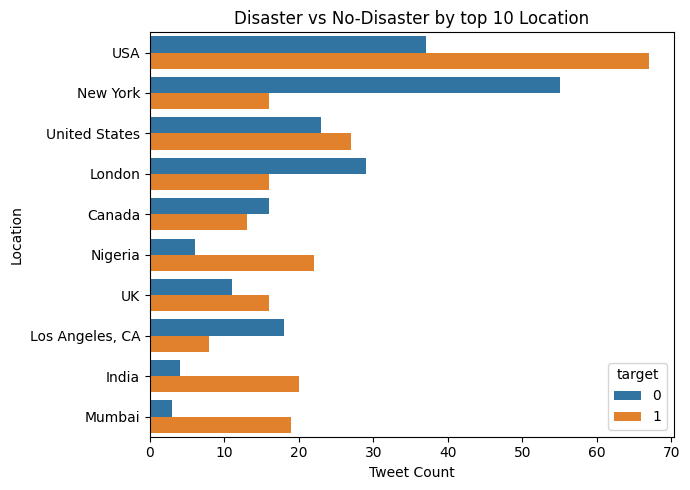

In [12]:
top_loc = train_df['location'].dropna().value_counts().head(10).index.tolist()
subset = train_df[train_df['location'].isin(top_loc)]

plt.figure(figsize=(7,5))
sns.countplot(data=subset, y='location', hue='target', order=top_loc)
plt.title("Disaster vs No-Disaster by top 10 Location")
plt.xlabel("Tweet Count")
plt.ylabel("Location")
plt.tight_layout()
plt.show()

* In ; US, India, Nigeria,and UK seems disaster is more than non disaster events.  

### I want to see some disaster and nondisaster tweets to understand the data

In [14]:

print("disaster tweets")
disaster_samples = train_df[train_df['target']==1]['text'].sample(5, random_state=42)
for i, tweet in enumerate(disaster_samples, 1):
    print(f"{i}. {tweet}")

print("\nNo disaster tweets")
non_disaster_samples = train_df[train_df['target']==0]['text'].sample(5, random_state=42)
for i, tweet in enumerate(non_disaster_samples, 1):
    print(f"{i}. {tweet}")

disaster tweets
1. Nearly 50 thousand people affected by floods in #Paraguay ? http://t.co/aw23wXtyjB http://t.co/ABgct9VFUa
2. Vladimir Putin Issues Major Warning But Is It Too Late To Escape Armageddon?
http://t.co/gBxafy1m1C
3. @DoctorFluxx @StefanEJones @spinnellii @themermacorn  No burning buildings and rob during a riot. That's embarrassing &amp; ruining this nation.
4. Telnet attacked from 124.13.172.40 (STREAMYX-HOME-SOUTHERN MY)
5. LONDON IS DROWNING AND IIII LIVE BY THE RIVEEEEEER

No disaster tweets
1. Everyday is a near death fatality for me on the road. Thank god is on my side.??
2. #Lifestyle Û÷It makes me sickÛª: Baby clothes deemed a Û÷hazardÛª http://t.co/0XrfVidxA2 http://t.co/oIHwgEZDCk
3. @Lenn_Len Probably. We are inundated with them most years!
4. A demoness with the voice of an angel. Like a siren's call beckoning me to the void. Don't ?? on thisÛ_ https://t.co/nPS3xpBKaQ
5. Next Man Up---AH SCREW THIS! I'm so tired of injuries.  

What happened to Camp Cupc

#### Will do data preprocessing based on EDA process
* There some character needs to clean. Some tweets contains words we could find in disaster moment but they are not disastorus like; fatality, death so on.  
* Before moving on the the cleaning the text in tweets, I am going to merge it with keywords! I believe that will add more variance to my data.

## Data Preprocessing
#### Text Cleaning

In [15]:
def clean_text(text):
    text = text.lower()

    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    text = re.sub(r'<.*?>', '', text)

    text = re.sub(r'[@#]\w+', '', text)
    
    text = re.sub(r'\s+', ' ', text)
    
    text = re.sub(r'[^\w\s]', '', text)

    text = re.sub(r'\d+', '', text)

    text = text.strip()
    
    return text

def remove_stopwords(text):

    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words and len(word) > 2]
    return ' '.join(filtered_words)


In [16]:
print("original text:")
sample_text = train_df['text'].iloc[0]
print(f"'{sample_text}'")

print("\nafter cleaning:")
cleaned_text = clean_text(sample_text)
print(f"'{cleaned_text}'")

print("\nsfter stopword removal:")
final_text = remove_stopwords(cleaned_text)
print(f"'{final_text}'")

original text:
'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

after cleaning:
'our deeds are the reason of this may allah forgive us all'

sfter stopword removal:
'deeds reason may allah forgive'


* This cleaning process is very useful why? Because there are many character is tweets not related what we are trying to achive like hashtags, html links, punctuations. Removing these noise from our data will help our model to perform well. Those special character doesnt carry information o help our models. 
* Regex is the best tool to achive this.  

In [17]:
train_processed = train_df.copy()
test_processed = test_df.copy()

In [19]:
# cleaing both test and train data
train_processed['text_cleaned'] = train_processed['text'].apply(clean_text)
train_processed['text_final'] = train_processed['text_cleaned'].apply(remove_stopwords)


test_processed['text_cleaned'] = test_processed['text'].apply(clean_text)
test_processed['text_final'] = test_processed['text_cleaned'].apply(remove_stopwords)


* I removed my preprocessed function and remove the stopwords from both train and text dataset.

In [20]:
# if there is empy text this code will remove it
train_processed = train_processed[train_processed['text_final'].str.len() > 0]
test_processed = test_processed[test_processed['text_final'].str.len() > 0]


In [21]:
print(f"train {len(train_processed)}")
print(f"test: {len(test_processed)}")

train 7609
test: 3262


#### Tokenization 

* Tokenization - convert words to numbers because computers can't understand text
* Example: "fire emergency" becomes [145, 67] where each number represents a word
* We need this because neural networks only work with numbers, not words
* Also we need to use tokenization for entire text to get same word to get same numerical representation!

In [22]:
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 50
EMBEDDING_DIM = 100

In [23]:
all_texts = list(train_processed['text_final']) + list(test_processed['text_final'])


tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(all_texts)


word_index = tokenizer.word_index
vocab_size = min(len(word_index) + 1, MAX_VOCAB_SIZE)

In [25]:
print(f"unique words: {len(word_index)}")
print(f"vocabulary size: {vocab_size}")
print(f"max sequence length: {MAX_SEQUENCE_LENGTH}")

unique words: 16451
vocabulary size: 10000
max sequence length: 50


* I am going to do padding operatons here, why we need paddings:
  
* Tweets have different lengths - Some have 5 words, others have 20 words
* Neural networks need same input size - Can't handle variable lengths


In [26]:
train_sequences = tokenizer.texts_to_sequences(train_processed['text_final'])
test_sequences = tokenizer.texts_to_sequences(test_processed['text_final'])
train_padded = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, 
                           padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH,
                          padding='post', truncating='post')

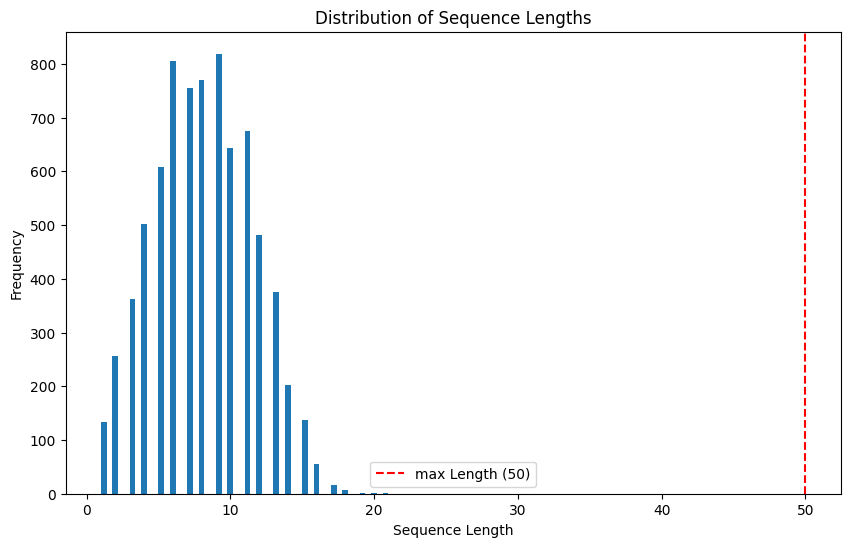

In [27]:
sequence_lengths = [len(seq) for seq in train_sequences]
plt.figure(figsize=(10, 6))
plt.hist(sequence_lengths, bins=50)
plt.axvline(x=MAX_SEQUENCE_LENGTH, color='red', linestyle='--', 
           label=f'max Length ({MAX_SEQUENCE_LENGTH})')
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#### Model Architecture

#### Model-1

# Basic LSTM Model:
- Simple, single direction LSTM (left to right only)
- Fewer parameters = faster training, less overfitting risk
- Good baseline to see if the problem is solvable


In [29]:
### I always start with the simple model to understand my data and its complexit
def create_basic_lstm_model(vocab_size, embedding_dim, max_length):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length, trainable=True),
        SpatialDropout1D(0.2),
        LSTM(64, dropout=0.2, recurrent_dropout=0.2),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

model_basic = create_basic_lstm_model(vocab_size, EMBEDDING_DIM, MAX_SEQUENCE_LENGTH)
model_basic.compile(optimizer=Adam(learning_rate=0.001),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])
model_basic.build(input_shape=(vocab_size, MAX_SEQUENCE_LENGTH))
model_basic.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (10000, 50, 100)            │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_1                  │ (10000, 50, 100)            │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (10000, 64)                 │          42,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (10000, 32)                 │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (10000, 32)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (10000, 1)                  │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,044,353 (3.98 MB)

 Trainable params: 1,044,353 (3.98 MB)

 Non-trainable params: 0 (0.00 B)

#### Model-2

- Reads text in both directions (forward AND backward)
- More complex = can capture better patterns but might overfit
- Like reading a sentence normally, then reading it backwards too
- - Should perform better if we have enough data

In [28]:
def create_bidirectional_lstm_model(vocab_size, embedding_dim, max_length):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length, trainable=True),
        SpatialDropout1D(0.3),
        Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)),
        Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.2)),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    return model

model_bidirectional = create_bidirectional_lstm_model(vocab_size, EMBEDDING_DIM, MAX_SEQUENCE_LENGTH)
model_bidirectional.compile(optimizer=Adam(learning_rate=0.001),
                           loss='binary_crossentropy', 
                           metrics=['accuracy'])
model_bidirectional.build(input_shape=(vocab_size, MAX_SEQUENCE_LENGTH))
model_bidirectional.summary()

2025-06-04 13:06:30.101396: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (10000, 50, 100)            │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ (10000, 50, 100)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (10000, 50, 128)            │          84,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (10000, 64)                 │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (10000, 64)                 │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (10000, 64)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (10000, 32)                 │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (10000, 32)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (10000, 32)                 │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (10000, 32)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (10000, 1)                  │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,133,025 (4.32 MB)

 Trainable params: 1,133,025 (4.32 MB)

 Non-trainable params: 0 (0.00 B)

#### Hyperparameter Configuration


- Different batch sizes and learning rates can make or break model performance
- Need to test combinations to find what works best for our disaster tweet data

In [30]:
HYPERPARAMS = {
    'batch_size': [16, 32],
    'learning_rate': [0.001, 0.0005],
    'epochs': 20,
    'patience': 5
}


In [31]:
y = train_processed['target'].values
X_train, X_val, y_train, y_val = train_test_split(
    train_padded, y, 
    test_size=0.1, 
    random_state=42, 
    stratify=y
)

In [32]:
def train_model_with_params(model, X_train, y_train, X_val, y_val, 
                           batch_size, learning_rate, epochs, patience):
    model.optimizer.learning_rate = learning_rate
    

    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, 
                                  restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, 
                                 min_lr=1e-7, verbose=1)
    
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    return history


In [33]:
def evaluate_model(model, X_val, y_val):

    y_pred_proba = model.predict(X_val)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()
    
    accuracy = np.mean(y_val == y_pred)
    
    return  accuracy, y_pred

In [34]:

best_acc = 0
best_params_basic = {}
results_basic = []

for batch_size in HYPERPARAMS['batch_size']:
    for learning_rate in HYPERPARAMS['learning_rate']:
        print(f"testing batch_size={batch_size}, learning_rate={learning_rate}")
        
      
        model = create_basic_lstm_model(vocab_size, EMBEDDING_DIM, MAX_SEQUENCE_LENGTH)
        model.compile(optimizer=Adam(learning_rate=learning_rate),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])
        
      
        history = train_model_with_params(
            model, X_train, y_train, X_val, y_val,
            batch_size, learning_rate, HYPERPARAMS['epochs'], HYPERPARAMS['patience']
        )
        
     
        accuracy, y_pred = evaluate_model(model, X_val, y_val)
        
        
        result = {
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'accuracy': accuracy,
            'final_val_loss': min(history.history['val_loss'])
        }
        results_basic.append(result)
        
        print(f"accuracy: {accuracy:.4f}")
        
        
        if accuracy > best_acc:
            best_acc = accuracy
            best_params_basic = {'batch_size': batch_size, 'learning_rate': learning_rate}
            best_model_basic = model

print(f"best parameters: {best_params_basic}")

testing batch_size=16, learning_rate=0.001
Epoch 1/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.5519 - loss: 0.6870 - val_accuracy: 0.5703 - val_loss: 0.6849 - learning_rate: 0.0010
Epoch 2/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - accuracy: 0.5651 - loss: 0.6871 - val_accuracy: 0.5703 - val_loss: 0.6833 - learning_rate: 0.0010
Epoch 3/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - accuracy: 0.5640 - loss: 0.6854 - val_accuracy: 0.5703 - val_loss: 0.6833 - learning_rate: 0.0010
Epoch 4/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - accuracy: 0.5731 - loss: 0.6846 - val_accuracy: 0.5703 - val_loss: 0.6837 - learning_rate: 0.0010
Epoch 5/20
427/428 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5770 - loss: 0.6822
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
428/428 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - accuracy: 0.5769 - loss: 0.6822 - val_accuracy: 0.5703 - val_loss: 0.6835 - learning_rate: 0.0010
Epoch 6/20
428/428 ━━━━━━━━━━━━━━━━

In [35]:
best_acc_bidirectional = 0
best_params_bidirectional = {}
results_bidirectional = []

for batch_size in HYPERPARAMS['batch_size']:
    for learning_rate in HYPERPARAMS['learning_rate']:
        print(f"testing batch_size={batch_size}, learning_rate={learning_rate}")
          
        model = create_bidirectional_lstm_model(vocab_size, EMBEDDING_DIM, MAX_SEQUENCE_LENGTH)
        model.compile(optimizer=Adam(learning_rate=learning_rate),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])
        
        
        history = train_model_with_params(
            model, X_train, y_train, X_val, y_val,
            batch_size, learning_rate, HYPERPARAMS['epochs'], HYPERPARAMS['patience']
        )
        
        
        accuracy, y_pred = evaluate_model(model, X_val, y_val)
        
      
        result = {
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'accuracy': accuracy,
            'final_val_loss': min(history.history['val_loss'])
        }
        results_bidirectional.append(result)
        
        print(f"accuracy: {accuracy:.4f}")
        
     
        if accuracy > best_acc_bidirectional :
            best_acc_bidirectional = accuracy
            best_params_bidirectional = {'batch_size': batch_size, 'learning_rate': learning_rate}
            best_model_bidirectional = model

print(f"best parameters: {best_params_bidirectional}")

testing batch_size=16, learning_rate=0.001
Epoch 1/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 63s 101ms/step - accuracy: 0.5875 - loss: 0.6752 - val_accuracy: 0.7792 - val_loss: 0.4994 - learning_rate: 0.0010
Epoch 2/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 41s 95ms/step - accuracy: 0.8294 - loss: 0.4192 - val_accuracy: 0.7753 - val_loss: 0.4886 - learning_rate: 0.0010
Epoch 3/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 43s 99ms/step - accuracy: 0.8890 - loss: 0.2995 - val_accuracy: 0.7740 - val_loss: 0.5209 - learning_rate: 0.0010
Epoch 4/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 42s 97ms/step - accuracy: 0.9166 - loss: 0.2215 - val_accuracy: 0.7582 - val_loss: 0.5747 - learning_rate: 0.0010
Epoch 5/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9396 - loss: 0.1668
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
428/428 ━━━━━━━━━━━━━━━━━━━━ 41s 95ms/step - accuracy: 0.9396 - loss: 0.1668 - val_accuracy: 0.7635 - val_loss: 0.6741 - learning_rate: 0.0010
Epoch 6/20
428/428 ━━━━━━━━━━━━━━━

In [41]:
print ('bidirectional LSTM: ', best_acc_bidirectional)
print ('basic LSTM: ', best_acc)

bidirectional LSTM:  0.7950065703022339
basic LSTM:  0.5703022339027596


In [37]:
final_model = best_model_bidirectional

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


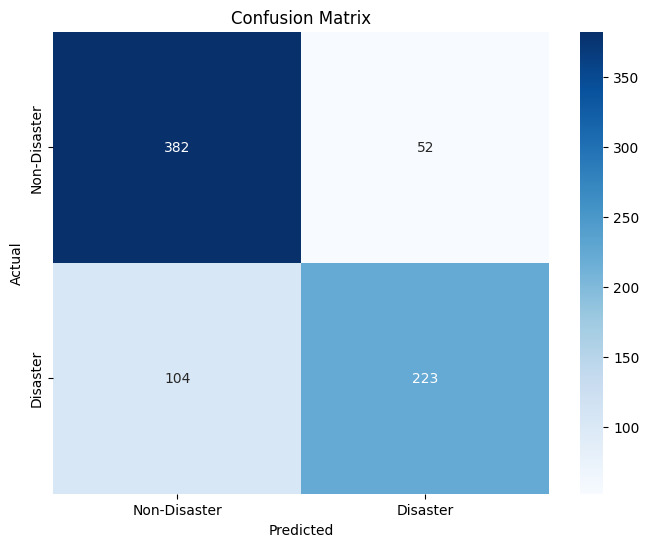

In [38]:
final_accuracy_detailed, y_pred_final = evaluate_model(final_model, X_val, y_val)


final_f1 = f1_score(y_val, y_pred_final)

cm = confusion_matrix(y_val, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=['Non-Disaster', 'Disaster'],
           yticklabels=['Non-Disaster', 'Disaster'])
plt.title(f'Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Confusion Matrix Analysis for Best Model (Bidirectional LSTM)
- [[382,  52],    <- Non-disaster tweets: 382 correct, 52 wrong (called disaster)
-  [104, 223]]    <- Disaster tweets: 223 correct, 104 wrong (missed disasters)


#### HUGE performance difference between models
* Basic LSTM stuck at 57% - barely better than random guessing (50%)
* Bidirectional LSTM achieved 79% - this is actually pretty good!

#### Why Basic LSTM failed:
* Notice how validation accuracy stayed EXACTLY at 0.57 for all combinations. This suggests the model couldn't learn meaningful patterns
* The model was too simple for the complexity of disaster tweet classification

#### Why Bidirectional LSTM succeeded:
* Reading text both forward and backward captured richer patterns
* Different hyperparameters actually made a difference (unlike basic model)
*  Best performance with batch_size=16, learning_rate=0.0005

#### confusion matrix:
* good at identifying non-disaster tweets (382 out of 434 correct)
* When it says "disaster," it's usually right (223 out of 275 predictions correct)



* Misses 104 out of 327 actual disasters - this is concerning!
* In real emergency scenarios, missing disasters could be dangerous
* Trade-off: prioritizes precision over recall for disaster detection

### Making predictions for competetiton 


In [39]:
test_preds = final_model.predict(test_padded)
test_preds_binary = (test_preds > 0.5).astype(int).flatten()

test_preds_binary = np.append(test_preds_binary, 0)

submission = pd.DataFrame({
    "id": test_df["id"].values,
    "target": test_preds_binary
})
submission.head()

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step


,id,target
0,0,1
1,2,0
2,3,1
3,9,0
4,11,1


In [ ]:
submission.to_csv('submission1.csv', index=False)

In [ ]:
len(test_preds_binary)